<a href="https://www.kaggle.com/code/noshintasnia/brain-stroke-detection-and-classification-by-image?scriptVersionId=147914494" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Validation/ischaemic/64 (14).jpg
/kaggle/input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Validation/ischaemic/99 (18).jpg
/kaggle/input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Validation/ischaemic/121 (14).jpg
/kaggle/input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Validation/ischaemic/103 (10).jpg
/kaggle/input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Validation/ischaemic/64 (7).jpg
/kaggle/input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Validation/ischaemic/122 (17).jpg
/kaggle/input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Validation/ischaemic/57 (15).jpg
/kaggle/input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Validation/ischaemic/55 (14).jpg
/kaggle/input/brain-stroke-prediction-

In [2]:
#import system libs 
import os
import itertools

# import data handling tools 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import confusion_matrix, classification_report

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [3]:

def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):
    # train dataframe 
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    # validation dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)

    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

In [4]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

In [5]:
def show_images(gen):
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes)
    images, labels = next(gen)        # get a batch size samples from the generator
    plt.figure(figsize= (20, 20))
    length = len(labels)              # length of batch size
    sample = min(length, 25)          # check if sample less than 25 images
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [6]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)     # get number of epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]    # get the loss value of epoch with the lowest validation loss
    index_acc = np.argmax(val_acc)       # get number of epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]     # get the loss value of epoch with the highest validation accuracy

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]	       # create x-axis by epochs count
    loss_label = f'best epoch= {str(index_loss + 1)}'  # label of lowest val_loss
    acc_label = f'best epoch= {str(index_acc + 1)}'    # label of highest val_accuracy
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

In [7]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

Found 1843 validated image filenames belonging to 2 classes.
Found 437 validated image filenames belonging to 2 classes.
Found 235 validated image filenames belonging to 2 classes.


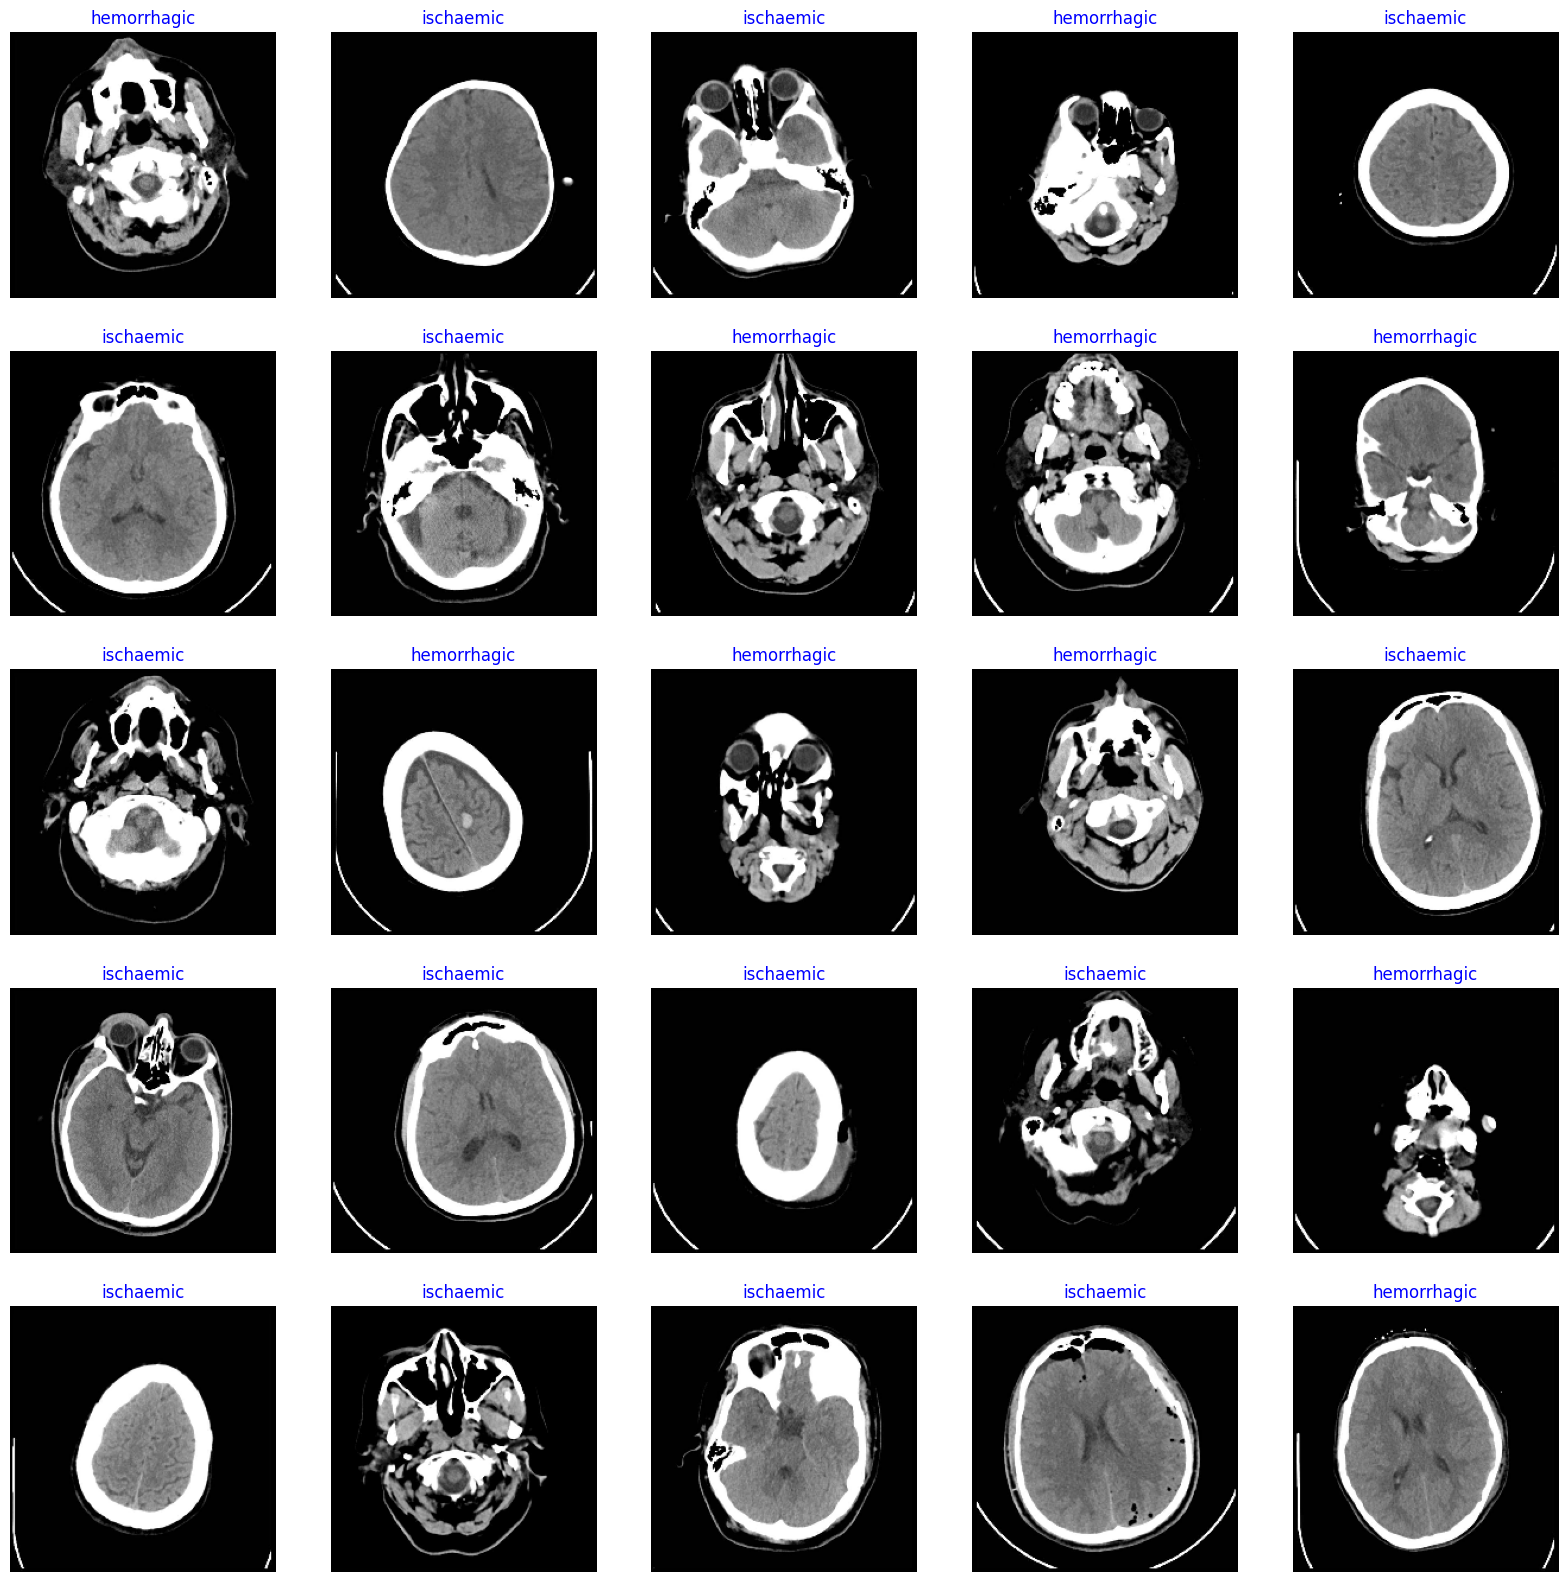

In [8]:
# Get Dataframes
train_dir = r'../input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Train'
valid_dir = r'../input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Test'
test_dir = r'../input/brain-stroke-prediction-ct-scan-image-dataset/Brain_Stroke_CT-SCAN_image/Validation'
train_df, valid_df, test_df = create_df(train_dir, valid_dir, test_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

show_images(train_gen)

In [9]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [10]:
history = model.fit(x= train_gen, epochs= 1, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False, initial_epoch= 0)

47/47 [==============================] - 2035s 43s/step - loss: 15.9300 - accuracy: 0.5855 - val_loss: 0.6445 - val_accuracy: 0.7025


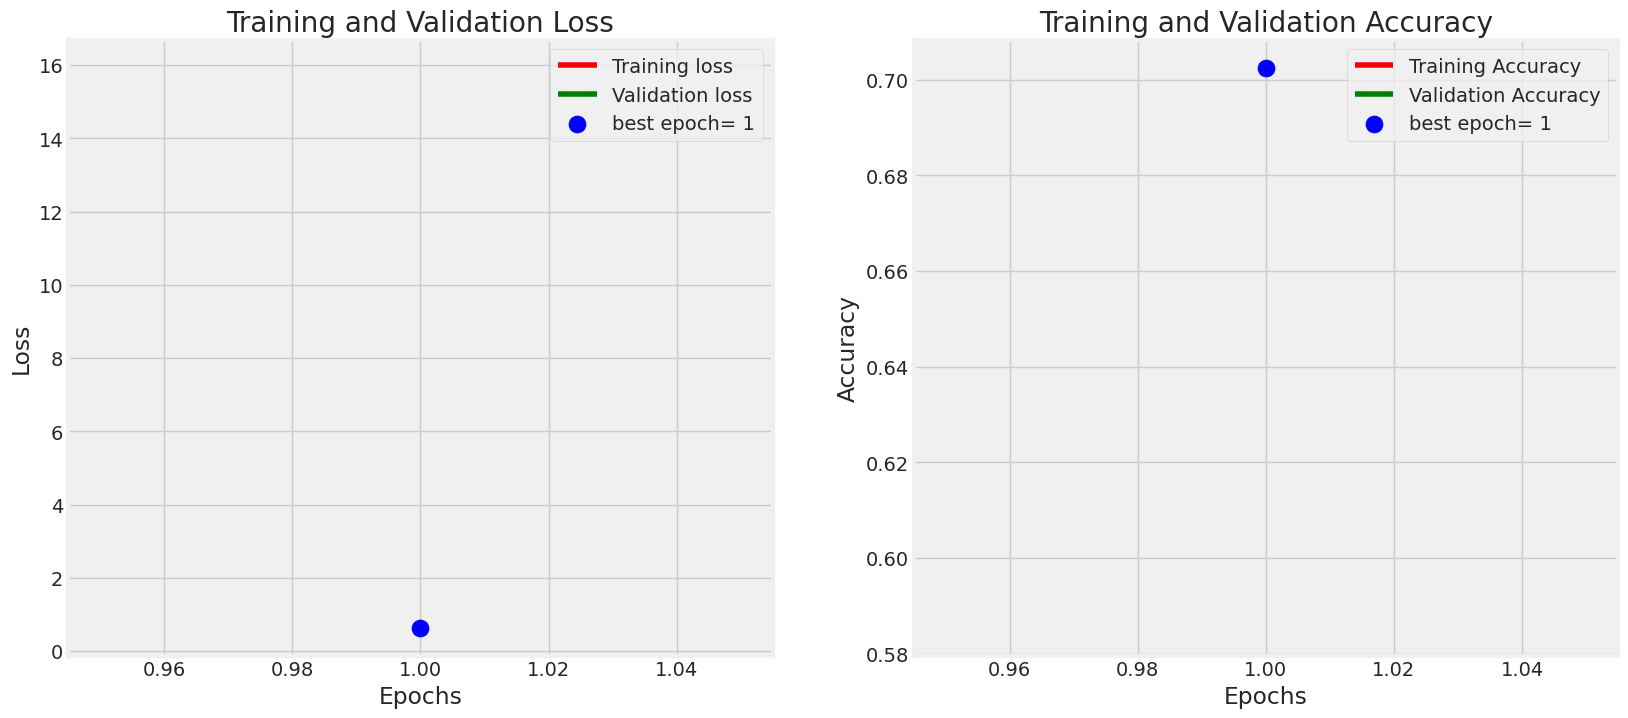

In [11]:
plot_training(history)

In [12]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 [==============================] - 69s 14s/step - loss: 0.6542 - accuracy: 0.6681
Train Loss:  0.6915912628173828
Train Accuracy:  0.5350000262260437
--------------------
Validation Loss:  0.644680917263031
Validation Accuracy:  0.699999988079071
--------------------
Test Loss:  0.6542390584945679
Test Accuracy:  0.6680850982666016


In [13]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

Confusion Matrix, Without Normalization
[[  0  78]
 [  0 157]]
              precision    recall  f1-score   support

 hemorrhagic       0.00      0.00      0.00        78
   ischaemic       0.67      1.00      0.80       157

    accuracy                           0.67       235
   macro avg       0.33      0.50      0.40       235
weighted avg       0.45      0.67      0.54       235



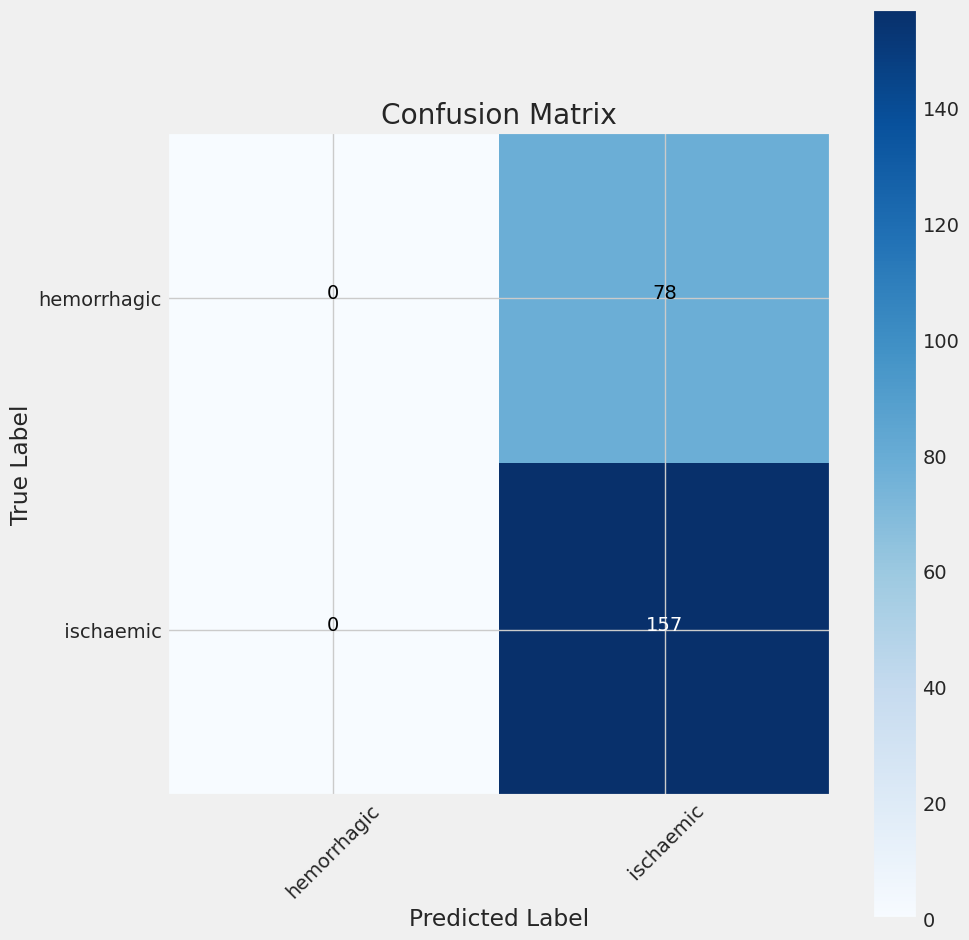

In [14]:
target_names = ['hemorrhagic', ' ischaemic']

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

In [15]:
history2 = model.fit(x= train_gen, epochs= 2, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False, initial_epoch= 0)

Epoch 1/2
47/47 [==============================] - 2037s 43s/step - loss: 0.6815 - accuracy: 0.5898 - val_loss: 0.6641 - val_accuracy: 0.7025
Epoch 2/2
47/47 [==============================] - 2050s 44s/step - loss: 0.6797 - accuracy: 0.5898 - val_loss: 0.6483 - val_accuracy: 0.7025


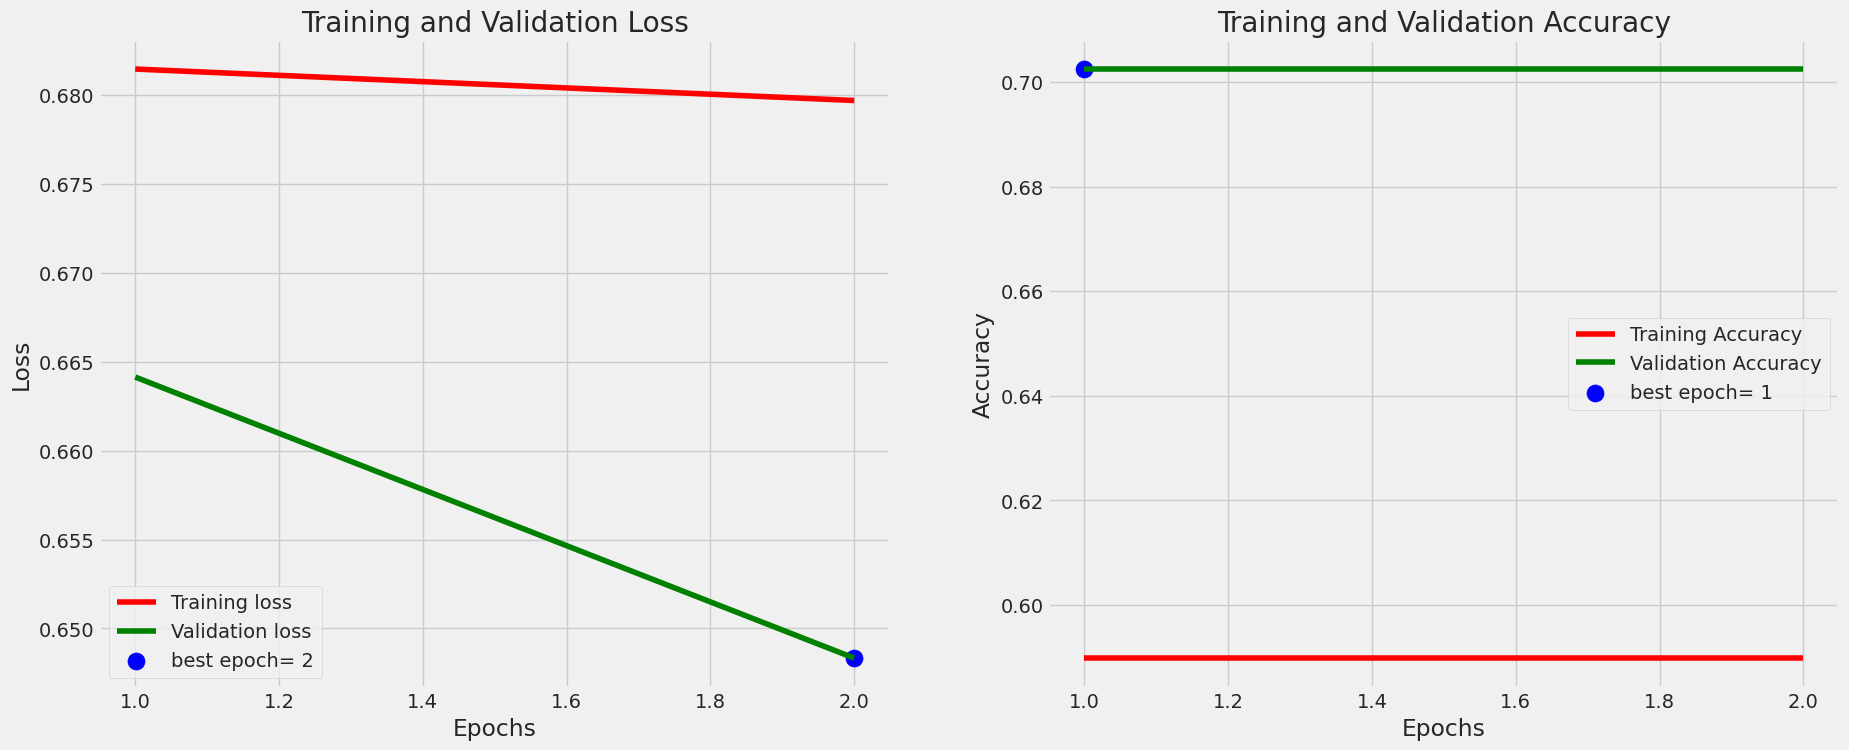

In [16]:
plot_training(history2)

In [17]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 [==============================] - 68s 14s/step - loss: 0.6574 - accuracy: 0.6681
Train Loss:  0.6661523580551147
Train Accuracy:  0.6349999904632568
--------------------
Validation Loss:  0.6462846994400024
Validation Accuracy:  0.7099999785423279
--------------------
Test Loss:  0.6574373245239258
Test Accuracy:  0.6680850982666016


In [18]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

Confusion Matrix, Without Normalization
[[  0  78]
 [  0 157]]
              precision    recall  f1-score   support

 hemorrhagic       0.00      0.00      0.00        78
   ischaemic       0.67      1.00      0.80       157

    accuracy                           0.67       235
   macro avg       0.33      0.50      0.40       235
weighted avg       0.45      0.67      0.54       235



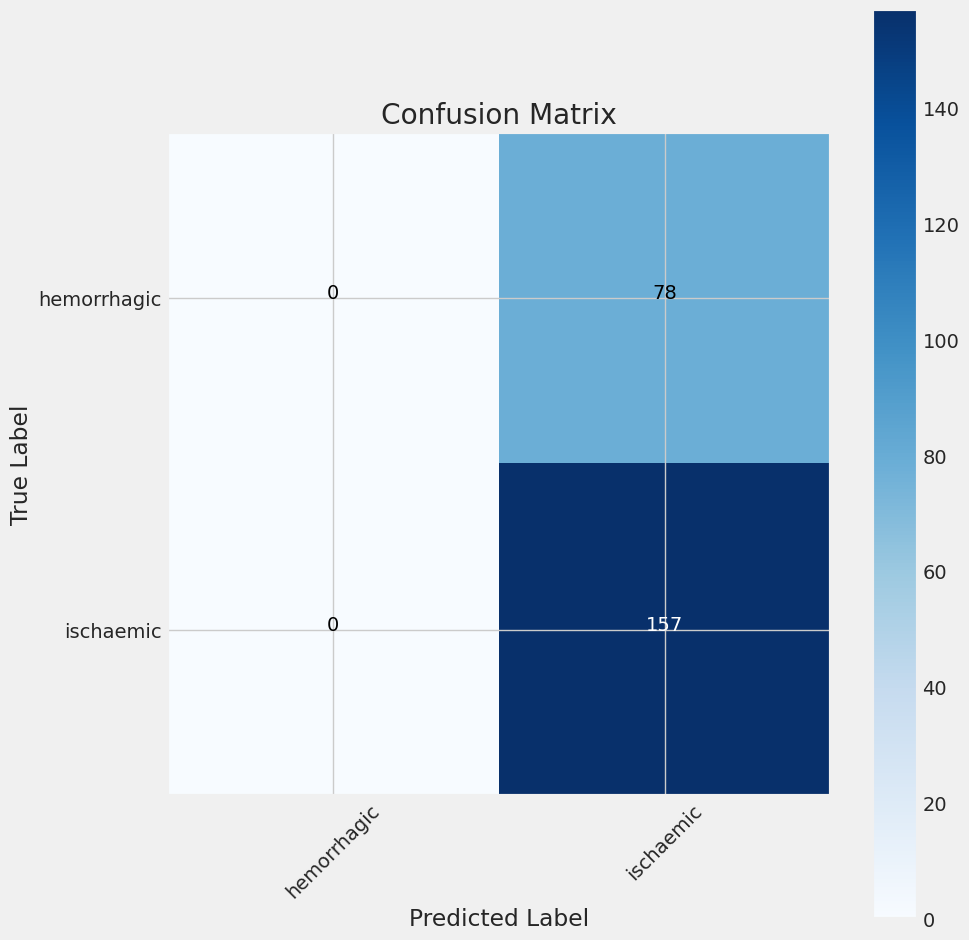

In [19]:
target_names = ['hemorrhagic', ' ischaemic']
# Define your class labels based on the actual class names
class_labels = ['hemorrhagic', 'ischaemic']

# Update your target_names
target_names = class_labels

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

In [20]:
history3 = model.fit(x= train_gen, epochs= 2, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False, initial_epoch= 0)

Epoch 1/2
47/47 [==============================] - 2050s 44s/step - loss: 0.6770 - accuracy: 0.5898 - val_loss: 0.6316 - val_accuracy: 0.7025
Epoch 2/2
47/47 [==============================] - 2024s 43s/step - loss: 0.6731 - accuracy: 0.5898 - val_loss: 0.5731 - val_accuracy: 0.7025


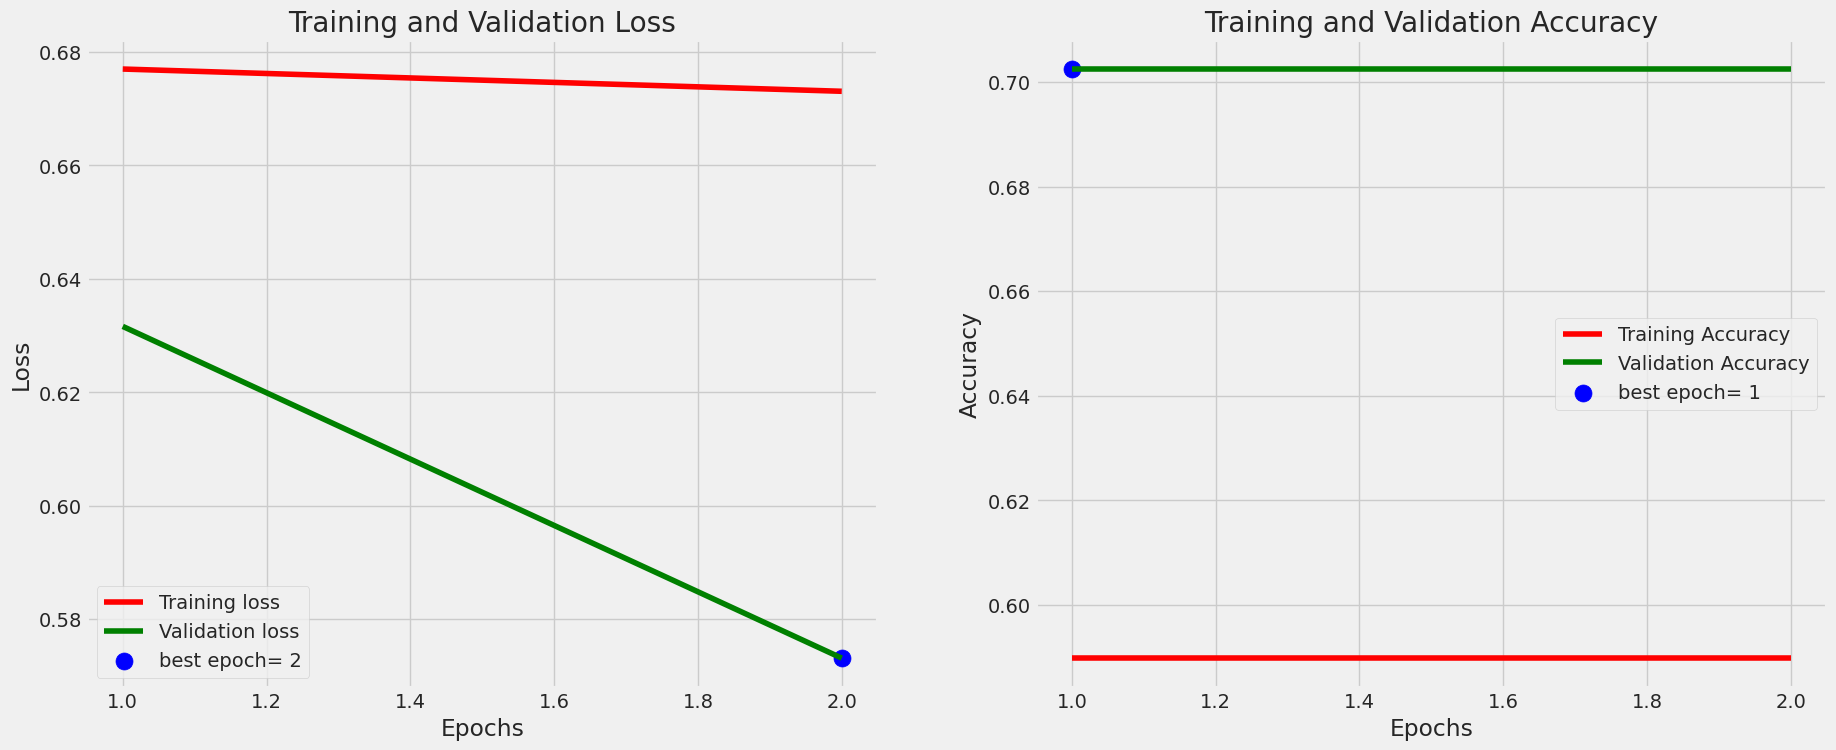

In [21]:
plot_training(history3)

In [22]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 [==============================] - 68s 14s/step - loss: 0.6102 - accuracy: 0.6681
Train Loss:  0.6271378397941589
Train Accuracy:  0.625
--------------------
Validation Loss:  0.5671183466911316
Validation Accuracy:  0.7200000286102295
--------------------
Test Loss:  0.6101882457733154
Test Accuracy:  0.6680850982666016


In [23]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

Confusion Matrix, Without Normalization
[[  0  78]
 [  0 157]]


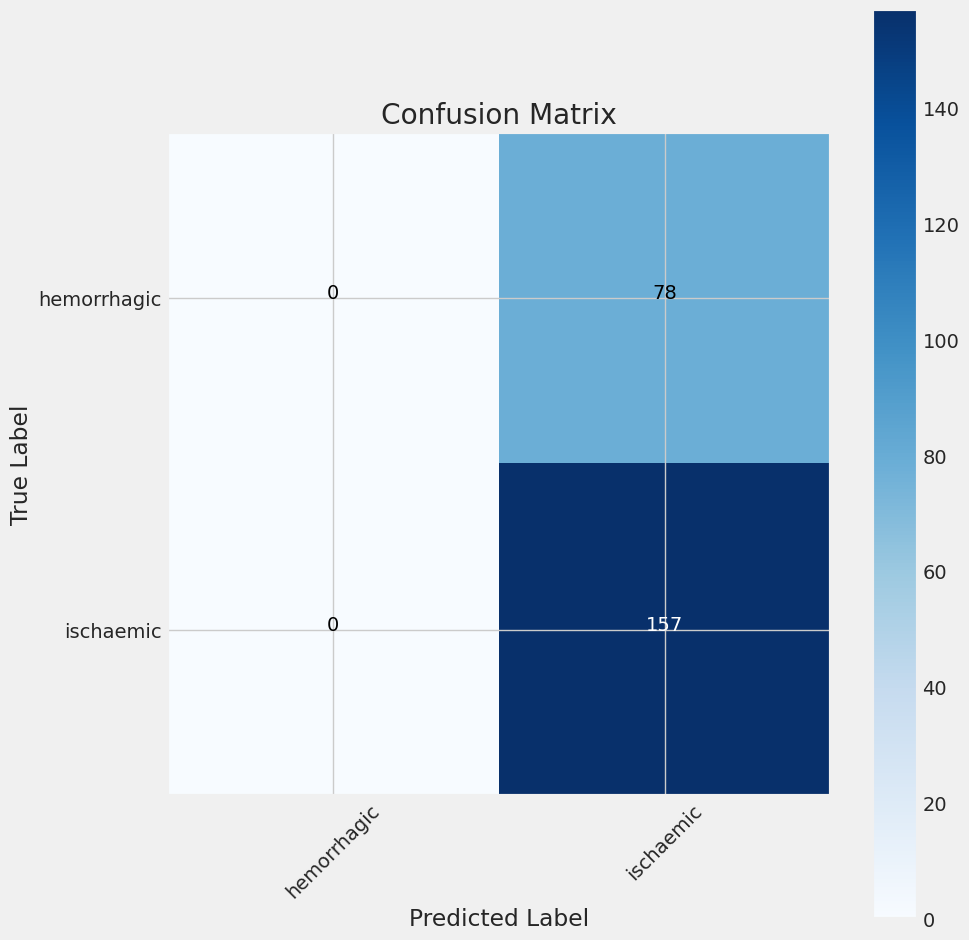

In [24]:
target_names = ['hemorrhagic', ' ischaemic']
# Define your class labels based on the actual class names
class_labels = ['hemorrhagic', 'ischaemic']

# Update your target_names
target_names = class_labels

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')

# Classification report